# Deep Active Learning simulation framework for Image Segmentation

---
**This notebook provides useful functions to implement active learning features for image segmentation.**<br>
**It is applied in this case for histology segmentation of myelin sheath along the spinal cord.**

Active Learning helps to efficiently train deep neural networks by selecting wisely the sample to annotate. 

---

### Preliminary remarks
##### Datasets
* This code takes as input patches of images and their corresponding masks, preprocessed to specific shapes. <br>
* It performs myelin segmentation (binary segmentation) on such images<br>
* Raw data preprocessing is detailled in the **Dataset_preparation_v2.0.ipynb** notebook. <br>
* A toy dataset composed of 2 SEM histology images preprocessed into 18 patches is available at **./deep_active_learning/datasets/** to run the notebook. 


##### Objectives
* The objective of the notebook is to **SIMULATE** active learning on histology data to efficiently train models to do segmentation. 
* This active learning simulation framework is based on convolutional neural network to perform binary segmentation and MC-dropout to measure the uncertainty on the samples. 


##### GPUs
* It is advised to run this notebook on GPUs since the models are trained multiple times (active learning iteration).
* **Training time**: the results where obtain by realizing 10 experiments, of 15 active-learning iteration each (ie. adding up to 15 patches to the initial dataset). On 2 NVIDIA GPUs, 1 active learning iteration was taking about 20 minutes to run.

---

This notebook is organized in several parts as listed here: 

**1. Data Loading**<br>
**2. Image segmentation**<br>
    - Utils
    - U-Net
    - Score measures
**3. Uncertainty measure**<br>
**4. Active Learning Loop**<br>
**5. Configuration parameters**<br>
**6. Main - Training**<br>
**7. Results analysis**<br>


In [1]:
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
import time
import random

from keras import backend as K
# from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout
from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
from keras import losses
from keras.preprocessing.image import ImageDataGenerator

import scipy.ndimage
from scipy.misc import imsave
from scipy.ndimage import morphology
from numpy import linalg

from itertools import islice
from scipy.ndimage.morphology import distance_transform_edt as edt

Using TensorFlow backend.


In [2]:
# Run  this line if you are using a GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = "3, 4"

In [3]:
cd ..

/home/tein/work/deep_active_learning


In [4]:
pwd

u'/home/tein/work/deep_active_learning'

# 1. Data Loading

In [5]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img

def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y


# 2. Image Segmentation

### 2.1. Utils

In [6]:
#### loss and metrics #####

def dice_coef(y_true, y_pred, smooth=1):
    """Compute Dice Coefficient between prediction and Ground Truth
    :param y_true: ground truth
    :param y_pred: prediction
    :param smooth: avoid division by 0
    :return: dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    """Dice loss to train a network
    :param y_true: ground truth
    :param y_pred: prediction
    :return: dice loss function
    """
    return 1 - dice_coef(y_true, y_pred)


def weighted_binary_crossentropy(y_true, y_pred):
    """Compute the weighted binary cross-entropy
    :param y_true: ground truth
    :param y_pred: prediction
    :return: weighted binary cross-entropy
    """
    b_ce = K.binary_crossentropy(y_true, y_pred)  # Calculate the binary crossentropy
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70  # Apply the weights
    weighted_b_ce = weight_vector * b_ce        
    return K.mean(weighted_b_ce) # Return the mean error


##### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)


##### Monte-Carlo Dropout : keep dropout active at test time #####
def call(self, inputs, training=None):
    """Override Dropout. Make it able at test time
    """
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs


def reset_weights(model):
    """Initialize weights of Neural Networks
    """
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)
            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)


def save_parameters(timestamp, params):
    """Save current parameters to text file
    :param timestamp:timestamp of the current run session
    :param params: dictionary of current parameters
    """
    
    if not os.path.exists(param_path):
        os.makedirs(param_path)
        print("Directory " , param_path ,  " Created ")
    
    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
    
def get_params():
    """Convert list of current parameters to dictionary 
    """
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict


def save_history(history, timestamp, iteration, history_path):
    """ Save training history in text file
    :param history: training history (numpy array)
    :param timestamp: timestamp of current run session
    :param iteration: active learning iteration number
    :param history_path: path to history text file
    """
    history_file = str(history_path + timestamp + '_history_iter_' +  str(iteration) +'_' + '.txt')
    txt_file = open(history_file,'w')
    txt_file.write(str(history))
    txt_file.close()

### 2.2. U-Net

In [7]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    pool1 = Dropout(dropout_proba)(pool1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    pool2 = Dropout(dropout_proba)(pool2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    pool3 = Dropout(dropout_proba)(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(dropout_proba)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(dropout_proba)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(dropout_proba)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)
    up8 = Dropout(dropout_proba)(up8)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)
    up9 = Dropout(dropout_proba)(up9)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    model = Model(outputs=conv10, inputs=inputs)

    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss= dice_coef_loss, 
                  metrics = [dice_coef])

    return model

### 2.3. Score Measure

In [8]:
## Score measure

def numeric_score(y_pred, y_true):
    """Compute True Positive, True Negative, False Positive, False Negative classifications
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: True Positive, True Negative, False Positive, False Negative
    """
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    FP = float(np.sum((y_pred == 1) & (y_true == 0)))
    FN = float(np.sum((y_pred == 0) & (y_true == 1)))
    TP = float(np.sum((y_pred == 1) & (y_true == 1)))
    TN = float(np.sum((y_pred == 0) & (y_true == 0)))
    return FP, FN, TP, TN


def jaccard_score(y_pred, y_true):
    """Compute Jaccard Score (= Intersection / Union) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Jaccard score value
    """
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    if union == 0:
        return 1.
    else:
        return float(intersection)/union
    
    
def pixel_wise_accuracy(y_true, y_pred):
    """Compute Pixel-wise accuracy (= number of well classified pixel / total number of pixel) 
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Pixel-wise accuracy value
    """
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    return 1 - np.count_nonzero(y_pred_f - y_true_f) / y_true_f.shape[1]
    

def precision_score(y_pred, y_true):
    """Compute precision (= TP / (TP+FP)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Precision score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FP) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FP) 
    

def sensitivity_score(y_pred, y_true):
    """Compute sensitivity (= TP / (TP+FN)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Sensitivity score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FN) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FN) 


# 3. Uncertainty Measure

In [9]:
def range_transform(sample):
    """
    Range normalization for 255 range of values
    :param sample: numpy array for normalize
    :return: normalize numpy array
    """
    if (np.max(sample) == 1):
        sample = sample * 255

    m = 255 / (np.max(sample) - np.min(sample))
    n = 255 - m * np.max(sample)
    return (m * sample + n) / 255


def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param model: unet model with Dropout layers.
    :return: averaged-thresholded predictions after nb_steps_prediction samples
    :return: overall uncertainty (not map)
    :return: uncertainty_map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)
    # averaged-thresholded predictions after np_step_prediction predicted samples
    X_prediction = cv2.threshold(np.mean(X, axis=0), threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(1 - prediction))
        return X_prediction, np.sum(np.multiply(var, transform)),  np.multiply(var, transform)

    else:
        return X_prediction, np.sum(np.sqrt(np.var(X, axis=0))), np.var(X, axis=0)


def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0) 

# 4. Active Learning Loop

In [10]:
def add_annotated_sample(original, added, added_index):
    """append the annotated samples to the training set
    """
    return np.vstack((original, added[added_index] ))


def data_splitting(X_set, training_size, validation_size, test_size):
    """generate indexes to split initial dataset in train, validation and test sets
    :param X_set: initial dataset (all the samples)
    :param training_size: size of the training set
    :param validation_size: size of the validation set
    :param test_size: size of the test set
    :return: indexes for labelled, unlabelled, test and validation sets
    """
    unlabelled_size = len(X_set) - training_size - validation_size - test_size
    index_labelled = np.arange(0, training_size, 1)
    index_unlabelled = np.arange(training_size, training_size + unlabelled_size, 1)
    index_test = np.arange(training_size + unlabelled_size, training_size + unlabelled_size + test_size, 1)
    index_validation = np.arange(training_size + unlabelled_size + test_size, len(X_set), 1)
    return index_labelled, index_unlabelled, index_test, index_validation

def split_for_simulation(X, y, index_labelled, index_unlabelled, index_test, index_validation):
    """split initial dataset in train, validation and test sets based on indexes 
    """
    X_labelled_0 = X[index_labelled]
    y_labelled_0 = y[index_labelled]

    X_unlabelled_0 = X[index_unlabelled]
    y_unlabelled_0 = y[index_unlabelled]

    X_test = X[index_test]
    y_test = y[index_test]
    
    X_validation = X[index_validation]
    y_validation = y[index_validation]
    
    return X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test, X_validation, y_validation


In [11]:
def scores(model, X_test, y_test, score_global):
    """Compute predictions scores on test set for the current active learning iteration
    :param model: trained Unet model
    :param X_test: test set
    :param y_test: test ground truth
    :param score global: numpy array with previous scores
    :return: numpy array with scores
    """
    uncertain_map = []
    uncertain = np.zeros(len(X_test))
    dice = np.zeros(len(X_test))
    jaccard = np.zeros(len(X_test))
    accuracy = np.zeros(len(X_test))
    sensitivity = np.zeros(len(X_test))
    precision = np.zeros(len(X_test))
    
    print("Computing predictions on test data ...\n")
    predictions = predict(X_test, model)

    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
        accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
        sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
        precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
        _ , uncertain[i], uncertain_map_i = compute_uncertain(sample, model)
        #uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)

    uncertain_map_array = np.asarray(uncertain_map)
    print("Done computing predictions on test data")
    metrics_array = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision),
                                np.mean(sensitivity)])
    score_global = np.vstack((score_global, metrics_array))
    return score_global


def balance_uncertainty(sample_pred, uncertainty, apply_edt):
    """Multiply uncertainty by a ratio to overcome unbalanced class issues
    :param sample_pred: prediction for a sample
    :param uncertainty: associated uncertainty measure
    :return: scaled uncertainty measure
    """
    if apply_edt == True:
        ratio = 1
    else:
        ratio = (1.0 / ((np.count_nonzero(sample_pred) + 1.0) / (512*512* 1.0)))
    return uncertainty * ratio


def uncertainty_for_ranking(model, X_set):
    """Compute uncertainty and uncertainty map for a set of images
    :param model: trained Unet model
    :param X_set: set of data
    :return: numpy array with uncertainty value and numpy array of uncertainty maps for each image of X_set,
    and final prediction for X_set, which is an AVERAGE OF THE nb_step_prediction FORWARD PASS PREDICTIONS
    """
    # uncertainty computation for unlabelled
    print("Computing predictions for unlabelled data ...\n")
    uncertain_map = []
    uncertainty = np.zeros(len(X_set))
    predictions = predict(X_set, model)
    X = []
    for i in range(len(X_set)):
        sample = X_set[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        X_i, uncertainty_i, uncertain_map_i = compute_uncertain(sample, model)
        uncertainty[i] = balance_uncertainty(X_i, uncertainty_i, apply_edt) # scale uncertainty
        uncertain_map.append(uncertain_map_i)
        X.append(X_i)
    uncertain_map_array = np.asarray(uncertain_map)
    return uncertainty, uncertain_map, X




def to_be_added_index(active_learning_iter_size, index, uncertain_unlabelled, dont_random):
    """ Select the most uncertain samples, retrieve its indice in order to add it to the training set
    :param active_learning_iter_size: number of samples selected to be added to the training set after each AL iteration
    :param index: list of already selected unlabelled samples
    :param uncertain_unlabelled: Uncertainty measures for all unlabelled samples
    :param dont_random: number of randomly selected samples to be added to the training set (< active_learning_iter_size)
    :return: list of selected samples indices after each AL iteration
    """
    uncert_unlab = np.copy(uncertain_unlabelled)
    if dont_random == 0:
        for m in range(active_learning_iter_size):
            to_be_added = np.argmax(uncert_unlab)
            while to_be_added in index:
                uncert_unlab[to_be_added] = 0
                to_be_added = np.argmax(uncert_unlab)
            index.append(to_be_added)
        return index
    else:
        for m in range(active_learning_iter_size - dont_random):
            to_be_added = np.argmax(uncertain_unlabelled)
            while to_be_added in index:
                uncertain_unlabelled[to_be_added] = 0
                to_be_added = np.argmax(uncertain_unlabelled)
            index = np.append(np.asarray(index), np.asarray(to_be_added))
        left_to_pick = np.setdiff1d(np.arange(len(uncertain_unlabelled)), np.asarray(index))
        random_index = np.random.choice(left_to_pick, dont_random, replace=False)
        return np.hstack((np.asarray(index, dtype = int), np.asarray(random_index, dtype = int)))


def to_be_added_random(active_learning_iter_size, index, uncertain_unlabelled):
    """ Select randomly samples to add to the training set (baseline)
    :param active_learning_iter_size: number of samples selected to be added to the training set after each AL iteration
    :param index: list of already selected unlabelled samples
    :param uncertain_unlabelled: Uncertainty measures for all unlabelled samples
    :return: list of selected samples indices after each AL iteration
    """
    lim = 0
    for m in range(active_learning_iter_size):
        to_be_added = random.randint(0, len(uncertain_unlabelled) -1)
        while to_be_added in index:
            if lim > 100: 
                to_be_added = np.delete[np.arange(len(uncertain_unlabelled), index)[0]]
            to_be_added = random.randint(0, len(uncertain_unlabelled)-1)
            lim = lim + 1
        index.append(to_be_added)
    return index

def save_results(result, name, session_name, random_bool):   
    if random_bool == True:
        np.save(str(results_path + name + session_name + "_random" ), result)
    else:
        np.save(str(results_path + name + session_name), result)


# 5. Configuration
**Default toy values for each parameters**<br>


In [ ]:
# PATH definition
param_path = '../params/'
results_path = './results/'
history_path = '../history/'

# paths to datasets
path_img = "./datasets/SEM_image.npy"
path_mask = "./datasets/SEM_mask.npy"


# image dimension (array)
img_rows = 512
img_cols = 512

# data augmentation
fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.2
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1

# Dropout at test time
K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

# training hyperparameters
batch_size = 5 
nb_initial_epochs = 5 # number of epochs
steps_per_epoch = 2 # number of steps per epochs
apply_augmentation = True # True or False: Apply Data Augmentation
nb_step_predictions = 5 # Number of Monte-Carlo samples to compute the uncertainty

dropout_proba = 0.2 # dropout probability

learning_rate = 1e-2
decay_rate = learning_rate / nb_initial_epochs

apply_edt = True # apply euclidean distance transform when computing the uncertainty
threshold = 0.5 # prediction threshold

nb_active_learning_iter = 5 # number of active learning iteration
active_learning_iter_size = 1 # number of patch added during each active learning iteration


# Datasets splitting
init_labelled_size = 3 
test_size = 3
validation_size = 4

random_bool = False # True: Baseline (random selection), False: Uncertainty based selection
dont_random = 0 # Number of randomly picked samples among the selected sample (e.g. adding 2 patches: 
                #1 selected with uncertainty, 1 picked randomly)

# name to save the results
session_name = "toy_trial"

# number of experiments: multiple experiments should be run to obtain a proper mean and 
# standard deviation of the results and overcome randomness of the network.
nb_experiement = 2

# 6. Main


In [29]:
# load data
X_full, y_full = load_data(path_img, path_mask, img_rows, img_cols )

index_labelled, index_unlabelled, index_test, index_validation = data_splitting(X_full, init_labelled_size,
                                                                                validation_size, test_size)

# split data into train (labelled, 30%), unlabelled (active learning simulation, 50%), test (20%)
X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test , X_validation, y_validation = split_for_simulation(
                                                                                                X_full, 
                                                                                                y_full,
                                                                                                index_labelled,
                                                                                                index_unlabelled,
                                                                                                index_test, 
                                                                                                index_validation)

score_average = []
indexes_experiments = []

for r in range(nb_experiement):
    print("\n\n*****************EXPERIMENT " + str(r+1) + " IS STARTING********************")
    
    rank_iter = np.zeros((nb_active_learning_iter, len(index_unlabelled)))
    uncertain_iter = np.zeros((nb_active_learning_iter, len(index_unlabelled)))

    # full experience
    uncertainty_unlabelled = np.zeros((nb_active_learning_iter, len(index_unlabelled)))
    to_be_annotated_index = []

    print("X_labelled shape = ", X_labelled_0.shape, "X_unlabelled shape = ", X_unlabelled_0.shape)
    print("X_test shape = ", X_test.shape,"X_validation shape = ", X_validation.shape )
    print("------------DATA SPLITTING DONE---------\n")

    timestamp = format(time.strftime('%m%d_%H%M_%S'))
    print "TIMESTAMP:", timestamp


    # START ACTIVE LEARNING ITERATION
    for i in range(nb_active_learning_iter):
        
        if random_bool == True:
            model_path = "../models/AL_model_random_" + str(i) + ".hdf5"
        else:
            model_path = "../models/AL_model_test_" + str(i) + ".hdf5"     # save trained model after each training
        
        print("\n---------Starting AL Iteration number " + str(i) + '----------')
        
        if i == 0: #initialization 
            X_labelled = X_labelled_0
            y_labelled = y_labelled_0
            X_unlabelled = X_unlabelled_0
            y_unlabelled = y_unlabelled_0
            score_global = np.zeros(5)
        else:
            # select the samples that are going to be annotated by expert   
            uncertain_iter[i] = uncertain_unlabelled
            if random_bool == True:
                to_be_annotated_index = to_be_added_random(active_learning_iter_size, to_be_annotated_index, 
                                                           uncertain_unlabelled)
            else:
                to_be_annotated_index = to_be_added_index(active_learning_iter_size, to_be_annotated_index, 
                                                          uncertain_unlabelled, dont_random)
                
            
            print "List of samples to be annotated by oracle=",  to_be_annotated_index
            # add this samples + masks to the train set 
            X_labelled = add_annotated_sample(X_labelled_0, X_unlabelled_0, to_be_annotated_index)
            y_labelled = add_annotated_sample(y_labelled_0, y_unlabelled_0, to_be_annotated_index)


            print("new X_labelled shape = ", X_labelled.shape, "new y_labelled shape =", y_labelled.shape)
            print("new X_unlabelled shape=", X_unlabelled.shape, "new y_unlabelled shape =", y_unlabelled.shape)


        ## Retrain with new dataset

        # data augmentation
        seed = 1
        train_img_generator = data_generator().flow(X_labelled, seed = seed, batch_size = batch_size,  shuffle=False)
        train_mask_generator = data_generator().flow(y_labelled, seed = seed, batch_size = batch_size, shuffle=False)
        train_generator = zip(train_img_generator, train_mask_generator)


        # load model
        model = unet_full_bn(dropout = True)

        # retrain from scratch after each iteration
        reset_weights(model)

        print("------------TRAINING -----------")
        save_parameters(timestamp, get_params()) # save parameters
        tensorboard = TensorBoard(log_dir = str("../logs2/" + str(timestamp)) + "_iter_" + str(i), write_images=True) # tensorboard
        history = model.fit_generator(train_generator, 
                                        validation_data = (X_validation, y_validation), 
                                        epochs = nb_initial_epochs, 
                                        verbose = 2,
                                        shuffle = True,
                                        steps_per_epoch = steps_per_epoch, 
                                        callbacks = [tensorboard])

        save_history(history.history, timestamp, i, history_path) # save training history
        model.save(model_path) # save fully trained model
        
        save_results(uncertain_iter, "uncertainty_iter_", session_name, random_bool)

        print("----------- Training done --------------")

        print("\n----------- RANKING -----------")
        # compute predictions / uncertainty for ranking on unlabelled dataset
        uncertain_unlabelled, uncertain_map, unlabelled_prediction = uncertainty_for_ranking(model, X_unlabelled)
        save_results(uncertain_map, "uncertainty_map_x_unlabelled_", session_name, random_bool)


        print("------------Computing scores on test set -----------")
        # score computation on X_test
        score_global = scores(model, X_test, y_test, score_global)
        save_results(score_global, "score_global_", session_name, random_bool)
    
    # save score global on test set for each experiment
    score_average.append(score_global)
    save_results(score_average, "score_average_", session_name, random_bool)

    
    # track selected samples over experiments
    indexes_experiments.append(to_be_annotated_index)
    print "Selected samples over experiments=", indexes_experiments
    save_results(indexes_experiments, "index_uncert_", session_name, random_bool)



Loading data...



*****************EXPERIMENT 1 IS STARTING********************
('X_labelled shape = ', (3, 1, 512, 512), 'X_unlabelled shape = ', (8, 1, 512, 512))
('X_test shape = ', (3, 1, 512, 512), 'X_validation shape = ', (4, 1, 512, 512))
------------DATA SPLITTING DONE---------

TIMESTAMP: 0630_0607_26

---------Starting AL Iteration number 0----------
------------TRAINING -----------
Epoch 1/10
 - 138s - loss: 0.5325 - dice_coef: 0.4675 - val_loss: 0.7898 - val_dice_coef: 0.2102
Epoch 2/10
 - 132s - loss: 0.5102 - dice_coef: 0.4898 - val_loss: 0.7990 - val_dice_coef: 0.2010
Epoch 3/10
 - 130s - loss: 0.4924 - dice_coef: 0.5076 - val_loss: 0.7973 - val_dice_coef: 0.2027
Epoch 4/10
 - 131s - loss: 0.4669 - dice_coef: 0.5331 - val_loss: 0.7872 - val_dice_coef: 0.2128
Epoch 5/10
 - 130s - loss: 0.4585 - dice_coef: 0.5415 - val_loss: 0.7660 - val_dice_coef: 0.2340
Epoch 6/10
 - 131s - loss: 0.4600 - dice_coef: 0.5400 - val_loss: 0.7365 - val_dice_coef: 0.2635
Epoch 7/10
 - 131s -

KeyboardInterrupt: 

# 7. Results

### 7.1. Dice on Test Set, compared with Random Baseline

In [30]:
score_average_random = np.load(results_path + "score_average_"+ session_name + ".npy")
score_average_uncert = np.load(results_path + "score_average_" + session_name + ".npy")

mean_uncert = np.mean(score_average_uncert, axis = 0)
mean_rand = np.mean(score_average_random, axis = 0)

std_uncert= np.std(score_average_uncert, axis = 0)
std_rand = np.std(score_average_random, axis = 0)

print"Random Baseline array (Mean and Std) shapes: ", mean_rand.shape, std_rand.shape
print"Uncertainty method array (Mean and Std) shapes: ", score_average_uncert.shape, score_average_random.shape

Random Baseline array (Mean and Std) shapes:  (4, 5) (4, 5)
Uncertainty method array (Mean and Std) shapes:  (2, 4, 5) (2, 4, 5)


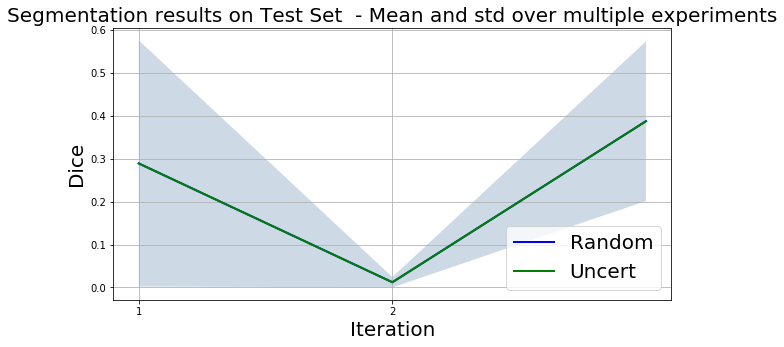

In [31]:
mu_rand = mean_rand[1:, 0]
sigma_rand = std_rand[1:, 0]

mu_uncert = mean_uncert[1:, 0]
sigma_uncert = std_uncert[1:, 0]

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(range(1, len(mu_rand)+1), mu_rand, lw=2, label='Random', color='blue')
ax.plot(range(1, len(mu_uncert)+1), mu_uncert, lw=2, label='Uncert', color='green')
ax.fill_between(range(1, len(mu_rand)+1), mu_rand+sigma_rand, mu_rand-sigma_rand, facecolor='blue', alpha=0.1)
ax.fill_between(range(1, len(mu_uncert)+1),mu_uncert+sigma_uncert, mu_uncert-sigma_uncert, facecolor='green', alpha=0.1)
ax.set_title('Segmentation results on Test Set  - Mean and std over multiple experiments', fontsize = 20)
ax.legend(loc='lower right', fontsize = 20)
ax.set_xlabel('Iteration', fontsize = 20)
ax.set_ylabel('Dice', fontsize = 20)
ax.set_xticks(range(1, len(mu_uncert)))
ax.grid()

### 7.2. Segmentation results on Test set for Top 3 MOST UNCERTAIN

In [32]:
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model, X_test)
predictions_test = np.asarray(predictions_test)
print "Top 3 most uncertain samples in test set: " , np.argsort(uncertain_test)[-3:]

Computing predictions for unlabelled data ...

Top 3 most uncertain samples in test set:  [1 2 0]


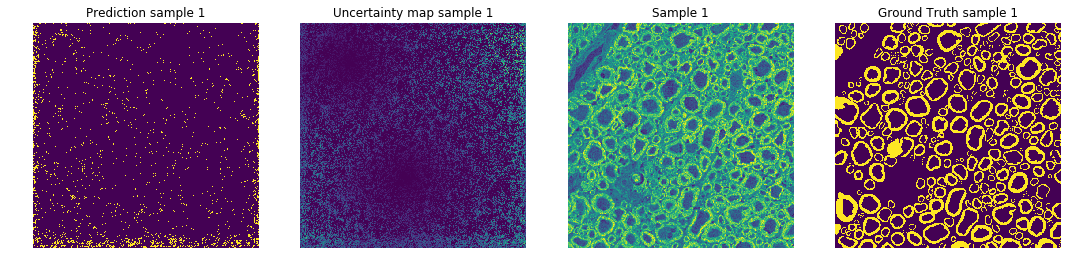

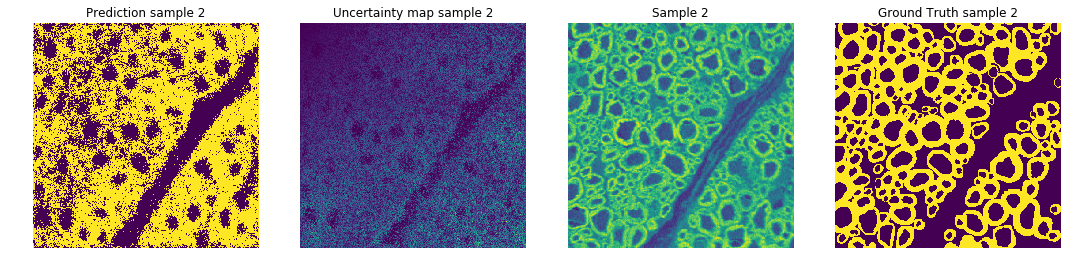

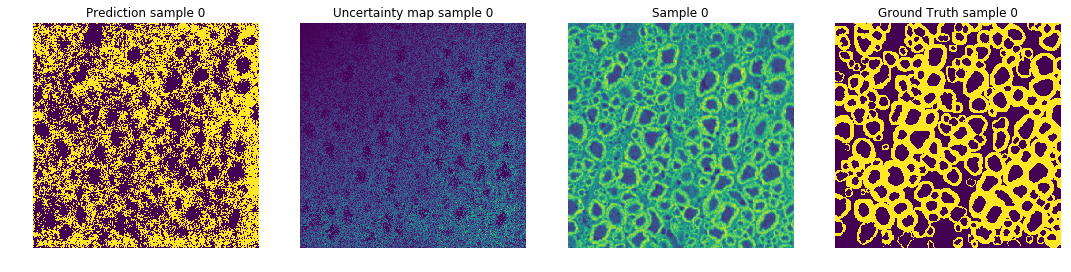

In [33]:
for indice in np.argsort(uncertain_test)[-3:]:
    plt.figure(figsize=(15,15))
    plt.subplot(141)
    plt.axis('off')
    plt.imshow(predictions_test[indice][:,:])
    plt.title("Prediction sample " + str(indice))
    plt.subplot(142)
    plt.axis('off')
    plt.imshow(np.asarray(uncertain_map_test)[indice, 0])
    plt.title("Uncertainty map sample "+ str(indice))
    plt.subplot(143)
    plt.axis('off')
    plt.imshow(X_test[indice][0,:,:])
    plt.title("Sample "+ str(indice))
    plt.subplot(144)
    plt.axis('off')
    plt.imshow(y_test[indice][0,:,:])
    plt.title("Ground Truth sample "+ str(indice))
    plt.tight_layout()
    plt.show()

### 7.3. Segmentation results on Test set at a specific iteration

Computing predictions for unlabelled data ...



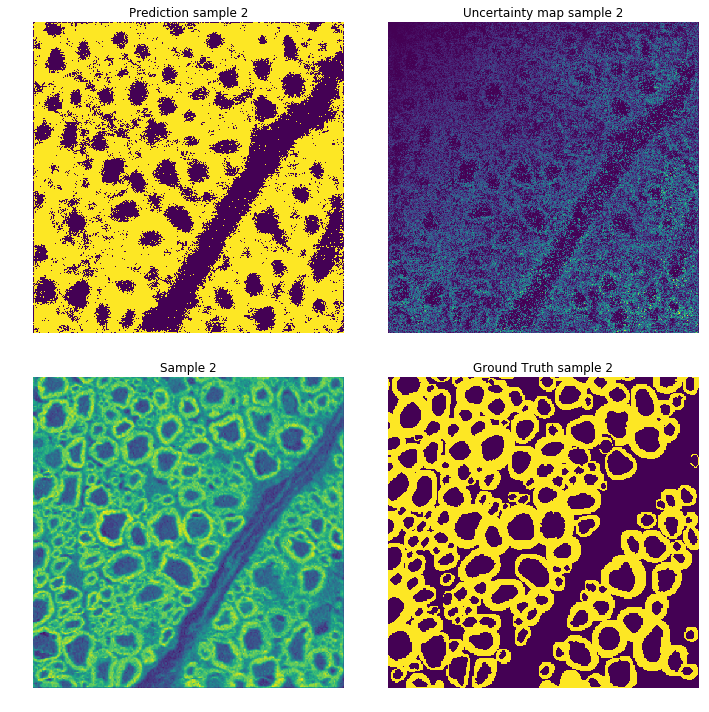

In [34]:
model_iter = unet_full_bn(dropout = True)
# load weights of your model at a certain iteration
model_iter.load_weights('../models/AL_model_test_5.hdf5')
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model_iter, X_test)
predictions_test = np.asarray(predictions_test)
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions_test[2][:,:])
plt.title("Prediction sample " + str(2))
plt.axis('off')
plt.subplot(222)
plt.imshow(np.asarray(uncertain_map_test)[2, 0])
plt.title("Uncertainty map sample "+ str(2))
plt.axis('off')
plt.subplot(223)
plt.imshow(X_test[2][0,:,:])
plt.title("Sample "+ str(2))
plt.axis('off')
plt.subplot(224)
plt.imshow(y_test[2][0,:,:])
plt.title("Ground Truth sample "+ str(2))
plt.axis('off')
plt.tight_layout()
plt.show()